<a href="https://colab.research.google.com/github/YanggWendy/sentiment-analysis/blob/main/SVM_and_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'comp4332/Project 1/'
assert FOLDERNAME is not None, "[1]Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/comp4332/Project 1/data'

## 1. Loading data and saving predictions

The same as previous tutorials, we use `pandas` as the basic tool to load & dump the data.
The key ingredient of our operation is the `DataFrame` in pandas.

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### A. Loading data

The following code shows how to load the datasets for this project.  
Among which, we do not release the labels (the "stars" column) for the test set. 
You may evaluate your trained model on the validation set instead.
However, your submitted predictions (``pred.csv``) should be generated on the test set.

Each year we release different data, so old models are not guaranteed to solve the new data.

In [5]:
def load_data(split_name='train', columns=['text', 'stars'], folder='data'):
    '''
        "split_name" may be set as 'train', 'valid' or 'test' to load the corresponding dataset.
        
        You may also specify the column names to load any columns in the .csv data file.
        Among many, "text" can be used as model input, and "stars" column is the labels (sentiment). 
        If you like, you are free to use columns other than "text" for prediction.
    '''
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        df = df.loc[:,columns]
        print("Success")
        return df
    except:
        print(f"Failed loading specified columns... Returning all columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        return df

Then you can extract the data by specifying the desired split and columns

In [10]:
train_df = load_data('train', columns=['text', 'stars'], folder='/content/drive/MyDrive/comp4332/Project 1/data')
valid_df = load_data('valid', columns=['text', 'stars'], folder='/content/drive/MyDrive/comp4332/Project 1/data')
# the test set labels (the 'stars' column) are not available! So the following code will instead return all columns
test_df = load_data('test', columns=['text', 'stars'], folder='/content/drive/MyDrive/comp4332/Project 1/data')

select [text, stars] columns from the train split
Success
select [text, stars] columns from the valid split
Success
select [text, stars] columns from the test split
Failed loading specified columns... Returning all columns from the test split


## 2. Preprocessing

Here are some preprocessing examples for your reference. For more details you may refer to the previous tutorials.

In [7]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

def lower(s):
    """
    :param s: a string.
    return a string with lower characters
    Note that we allow the input to be nested string of a list.
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: 'text mining is to identify useful information.'
    """
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")


def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)


def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

import numpy as np

def get_onehot_vector(feats, feats_dict):
    """
    :param data: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

In [11]:
train_df = load_data('train',folder=path)[:5000]
valid_df = load_data('valid',folder=path)
x_train = train_df['text']
y_train = train_df['stars']
x_valid = valid_df['text']
y_valid = valid_df['stars']
x_test = test_df['text']

select [text, stars] columns from the train split
Success
select [text, stars] columns from the valid split
Success


#Use pre-trained bert model
We use pre-trained bert model "nlptown/bert-base-multilingual-uncased-sentiment" to do the prediction

In [9]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel,BertTokenizerFast
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 102.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 28.5 MB/s eta 0:00:00


In [ ]:
def sentiment_score(review, max_len):
    temp = []
    for rev in review:
      tokens = tokenizer.encode(rev[0:max_len], return_tensors='pt')
      result = model(tokens)
      temp.append(int(torch.argmax(result.logits))+1)
    return temp

In [13]:
max_len = 512

tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment',max_length= max_len, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [ ]:
y_pred = sentiment_score(x_valid,max_len)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

              precision    recall  f1-score   support

           1       0.70      0.68      0.69       292
           2       0.33      0.45      0.38       163
           3       0.49      0.45      0.47       232
           4       0.48      0.50      0.49       421
           5       0.82      0.77      0.79       892

    accuracy                           0.64      2000
   macro avg       0.56      0.57      0.56      2000
weighted avg       0.65      0.64      0.64      2000




[[199  69  11   5   8]
 [ 46  74  29   8   6]
 [ 12  44 104  64   8]
 [ 11  19  49 210 132]
 [ 16  18  20 153 685]]
accuracy 0.636


In [ ]:
max_len = 200

tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment',max_length= max_len, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [ ]:
y_pred = sentiment_score(x_valid,max_len)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

              precision    recall  f1-score   support

           1       0.64      0.62      0.63       292
           2       0.24      0.32      0.27       163
           3       0.37      0.35      0.36       232
           4       0.39      0.35      0.37       421
           5       0.74      0.74      0.74       892

    accuracy                           0.56      2000
   macro avg       0.48      0.48      0.48      2000
weighted avg       0.57      0.56      0.56      2000




[[180  66  24   8  14]
 [ 43  52  38  12  18]
 [ 12  39  82  75  24]
 [ 11  26  56 149 179]
 [ 34  33  23 139 663]]
accuracy 0.563


In [ ]:
max_len = 400

tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment',max_length= max_len, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
y_pred = sentiment_score(x_valid,max_len)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

              precision    recall  f1-score   support

           1       0.70      0.64      0.67       292
           2       0.30      0.42      0.35       163
           3       0.47      0.41      0.44       232
           4       0.46      0.48      0.47       421
           5       0.79      0.76      0.77       892

    accuracy                           0.61      2000
   macro avg       0.54      0.54      0.54      2000
weighted avg       0.63      0.61      0.62      2000




[[188  74  13   6  11]
 [ 40  69  33  13   8]
 [ 11  45  95  69  12]
 [ 11  17  44 203 146]
 [ 20  28  17 152 675]]
accuracy 0.615


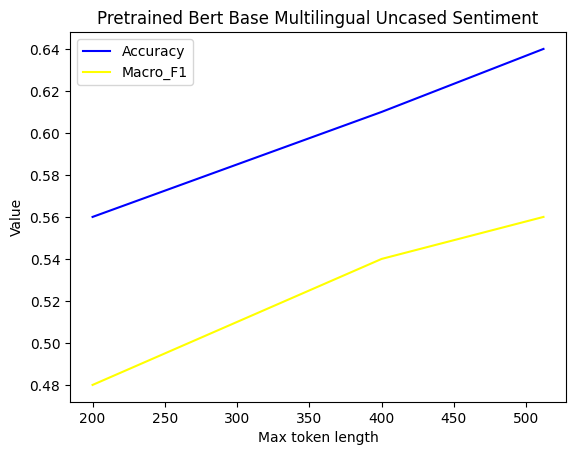

In [39]:
max_length = [200, 400, 512]
accuracy = [0.56,0.61,0.64]
macro_f1 = [0.48,0.54,0.56]

plt.plot(max_length, accuracy, label="Accuracy", color="blue")
plt.plot(max_length,macro_f1, label="Macro_F1", color="yellow")
plt.xlabel("Max token length")
plt.ylabel("Value")
plt.title('Pretrained Bert Base Multilingual Uncased Sentiment')
plt.legend()

#Support Vector Machine Algorithm (SVM)

In [ ]:
#Importing the necessary packages and libaries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from itertools import chain
from collections import Counter

In [ ]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = [f for f, cnt in feat_cnt.most_common(max_size)]
    else:
        valid_feats = list()
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]        
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_onehot_vector(feats, feats_dict):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

In [ ]:
# extract features
train_tokens = [tokenize(text) for text in x_train]
test_tokens = [tokenize(text) for text in x_valid]

train_stemmed = [stem(tokens) for tokens in x_train]
test_stemmed = [stem(tokens) for tokens in x_valid]

train_stemmed = [filter_stopwords(tokens) for tokens in train_stemmed]
test_stemmed = [filter_stopwords(tokens) for tokens in test_stemmed]

train_2_gram = [n_gram(tokens, 2) for tokens in train_stemmed]
train_3_gram = [n_gram(tokens, 3) for tokens in train_stemmed]
test_2_gram = [n_gram(tokens, 2) for tokens in test_stemmed]
test_3_gram = [n_gram(tokens, 3) for tokens in test_stemmed]

# build the feature list
train_feats = list()
for i in range(len(x_train)):
    train_feats.append(
        train_stemmed[i] + train_2_gram[i] + train_3_gram[i])
test_feats = list()
for i in range(len(x_valid)):
    test_feats.append(
        test_stemmed[i] + test_2_gram[i] + test_3_gram[i])

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=5)

# build the feats_matrix
# convert each example to a ont-hot vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_onehot_vector(f, feats_dict) for f in train_feats])
test_feats_matrix = np.vstack(
    [get_onehot_vector(f, feats_dict) for f in test_feats])


Size of features: 5802


<ipython-input-33-30bba320808e>:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vector = np.zeros(len(feats_dict), dtype=np.float)


In [ ]:
train_lens = [len(i) for i in train_feats_matrix]
plt.hist(train_lens)

In [ ]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(train_feats_matrix, y_train)
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(train_feats_matrix, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(train_feats_matrix, y_train)
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(train_feats_matrix, y_train)

In [ ]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(train_feats_matrix, y_train)

In [ ]:
'''
#stepsize in the mesh, it alters the accuracy of the plotprint
#to better understand it, just play with the value, change it and print it
h = .01
#create the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
# create the title that will be shown on the plot
titles = ['Linear kernel','RBF kernel','Polynomial kernel','Sigmoid kernel']
'''

NameError: ignored

In [ ]:
for i, clf in enumerate((linear, rbf, poly, sig)):
    #defines how many plots: 2 rows, 2columns=> leading to 4 plots
    plt.subplot(2, 2, i + 1) #i+1 is the index
    #space between plots
    plt.subplots_adjust(wspace=0.4, hspace=0.4) 
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.PuBuGn, alpha=0.7)
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.PuBuGn,     edgecolors='grey')
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
    plt.show()

In [ ]:
linear_pred = linear.predict(test_feats_matrix)
poly_pred = poly.predict(test_feats_matrix)
rbf_pred = rbf.predict(test_feats_matrix)
sig_pred = sig.predict(test_feats_matrix)

In [ ]:
# retrieve the accuracy and print it for all 4 kernel functions
accuracy_lin = linear.score(test_feats_matrix, y_valid)
accuracy_poly = poly.score(test_feats_matrix, y_valid)
accuracy_rbf = rbf.score(test_feats_matrix, y_valid)
accuracy_sig = sig.score(test_feats_matrix, y_valid)
print('Accuracy Linear Kernel:', accuracy_lin)
print("Accuracy Polynomial Kernel:", accuracy_poly)
print("Accuracy Radial Basis Kernel:", accuracy_rbf)
print('Accuracy Sigmoid Kernel:', accuracy_sig)

In [ ]:
print('Linear Kernel:\n', classification_report(y_valid, linear_pred))
print("Polynomial Kernel:\n", classification_report(y_valid, poly_pred))
print("Radial Basis Kernel:\n", classification_report(y_valid, rbf_pred))
print('Sigmoid Kernel:\n', classification_report(y_valid, sig_pred))

#Pretrain BERT Base

In [14]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [16]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [17]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [18]:
from transformers import BertTokenizer

# Load the BERT tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-small')

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [19]:
# Concatenate train data and test data
all_reviews = np.concatenate([x_train, x_valid])

# Encode our concatenated data
encoded_reviews = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_reviews]

# Find the maximum length

max_len = max([len(sent) for sent in encoded_reviews])
'''
for sent in encoded_reviews:
  if len(sent) == max_len:
    print(sent)
'''
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (768 > 512). Running this sequence through the model will result in indexing errors


Max length:  1155


In [20]:
# Specify `MAX_LEN`
MAX_LEN = 512

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([x_train[0]])[0].squeeze().numpy())
print('Original: ', x_train[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(x_train)
val_inputs, val_masks = preprocessing_for_bert(x_valid)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  Best Sunday buffet in the two cities of Charlotte and Concord!    Every week they change 80% of the buffet on Sunday so you never get bored.   And the attention to Customer Service was outstanding.    

Good for them.  Fresh ingredients and perfect atmosphere.    Loved it. 

Pat & Ali Hughes
Token IDs:  [101, 2190, 4465, 28305, 1999, 1996, 2048, 3655, 1997, 5904, 1998, 16557, 999, 2296, 2733, 2027, 2689, 3770, 1003, 1997, 1996, 28305, 2006, 4465, 2061, 2017, 2196, 2131, 11471, 1012, 1998, 1996, 3086, 2000, 8013, 2326, 2001, 5151, 1012, 2204, 2005, 2068, 1012, 4840, 12760, 1998, 3819, 7224, 1012, 3866, 2009, 1012, 6986, 1004, 4862, 8099, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [21]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train-1)
val_labels = torch.tensor(y_valid-1)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [22]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 5

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
  

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 166 µs, sys: 0 ns, total: 166 µs
Wall time: 210 µs


In [23]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4, freeze_bert = False ):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert= freeze_bert)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)
    #bert_classifier

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [40]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    best_val_loss = float('inf')
    train_acc = []
    train_loss_his = []
    train_acc_his = []
    valid_loss_his = []
    valid_acc_his = []
    early_stopping_threshold_count = 0
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            #b_input_ids, b_attn_mask, b_labels = tuple(batch)
  
            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            #Calculate train accuracy
            output = torch.argmax(logits, dim=1).flatten()
            accuracy = (output == b_labels).cpu().numpy().mean() * 100
            
            train_acc.append(accuracy)

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        train_loss_his.append(avg_train_loss)
        train_acc_his.append(np.mean(train_acc))
        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy, y_true, y_pred, best_val_loss, early_stopping_threshold_count = evaluate(model, val_dataloader, best_val_loss, early_stopping_threshold_count)
            valid_loss_his.append(val_loss)
            valid_acc_his.append(val_accuracy)
            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
        if early_stopping_threshold_count >= 1:
          print("Early stopping")
          break
    
    print("Training complete!")
    return y_true, y_pred, train_loss_his, train_acc_his, valid_loss_his, valid_acc_his


def evaluate(model, val_dataloader, best_val_loss, early_stopping_threshold_count):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    y_pred = []
    y_true = []

    with torch.no_grad():
      total_loss_val = 0

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        #b_input_ids, b_attn_mask, b_labels = tuple(batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
       
        val_accuracy.append(accuracy)

        y_true += b_labels.tolist()
        y_pred += preds
        total_loss_val += loss.item()

    if best_val_loss > total_loss_val:
        best_val_loss = total_loss_val
        torch.save(model, f"/content/drive/MyDrive/comp4332/Project 1/best_bert_model_1.pt")
        print("Saved model")
        early_stopping_threshold_count = 0
    else:
        early_stopping_threshold_count += 1
                

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy, y_true, y_pred, best_val_loss, early_stopping_threshold_count

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=3, freeze_bert = True)
y_true, y_pred, train_loss_his, train_acc_his, valid_loss_his, valid_acc_his = train(bert_classifier, train_dataloader, val_dataloader, epochs=3, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.608202   |     -      |     -     |   4.87   
   1    |   40    |   1.524683   |     -      |     -     |   4.62   
   1    |   60    |   1.490517   |     -      |     -     |   4.62   
   1    |   80    |   1.442866   |     -      |     -     |   4.61   
   1    |   100   |   1.441232   |     -      |     -     |   4.62   
   1    |   120   |   1.390112   |     -      |     -     |   4.62   
   1    |   140   |   1.353363   |     -      |     -     |   4.61   
   1    |   156   |   1.396969   |     -      |     -     |   3.53   
----------------------------------------------------------------------
   1    |    -    |   1.458466   |  1.370692  |   44.64   |   49.66  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elaps

In [ ]:
y_pred = [t.cpu().numpy() for t in y_pred]
print(classification_report(y_true, y_pred))
print("\n\n")
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.02      0.03       292
           1       0.00      0.00      0.00       163
           2       0.00      0.00      0.00       232
           3       0.00      0.00      0.00       421
           4       0.45      1.00      0.62       892

    accuracy                           0.45      2000
   macro avg       0.29      0.20      0.13      2000
weighted avg       0.35      0.45      0.28      2000




[[  5   0   0   0 287]
 [  0   0   0   0 163]
 [  0   0   0   0 232]
 [  0   0   0   0 421]
 [  0   0   0   0 892]]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=10, freeze_bert = True)
y_true, y_pred, train_loss_his_freeze, train_acc_his_freeze, valid_loss_his_freeze, valid_acc_his_freeze = train(bert_classifier, train_dataloader, val_dataloader, epochs=10, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.608362   |     -      |     -     |   22.05  
   1    |   40    |   1.521587   |     -      |     -     |   21.79  
   1    |   60    |   1.485709   |     -      |     -     |   22.74  
   1    |   80    |   1.435726   |     -      |     -     |   22.68  
   1    |   100   |   1.431415   |     -      |     -     |   22.15  
   1    |   120   |   1.382351   |     -      |     -     |   22.19  
   1    |   140   |   1.341588   |     -      |     -     |   22.51  
   1    |   156   |   1.390833   |     -      |     -     |   17.14  
----------------------------------------------------------------------
Saved model
   1    |    -    |   1.452207   |  1.359268  |   44.64   |  241.41  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val A

In [29]:
print("train_loss_his:",train_loss_his_freeze)
print("train_acc_his:",train_acc_his_freeze)
print("valid_loss_his:",valid_loss_his_freeze)
print("valid_acc_his:",valid_acc_his_freeze)

train_loss_his: [1.452206990521425, 1.3127583010940795, 1.2448728388282144, 1.1943219193987027, 1.1607605993368064, 1.1390186236922148, 1.118046912797697, 1.1052495036155554, 1.0970297258371, 1.0927470531433252]
train_acc_his: [41.222133757961785, 43.11305732484077, 44.69214437367304, 46.357484076433124, 47.738853503184714, 48.84885881104034, 49.806642402183805, 50.574741242038215, 51.20753715498938, 51.67794585987261]
valid_loss_his: [1.3592679141059754, 1.2649845906666346, 1.203606439015222, 1.1611814451596094, 1.1307576336557903, 1.1082498563660517, 1.0915917792017498, 1.0800976459942166, 1.072940693015144, 1.0700956583023071]
valid_acc_his: [44.642857142857146, 45.882936507936506, 49.25595238095238, 51.88492063492063, 53.37301587301587, 54.76190476190476, 55.8531746031746, 56.34920634920635, 56.6468253968254, 56.99404761904762]


In [30]:
y_pred = [t.cpu().numpy() for t in y_pred]
print(classification_report(y_true, y_pred))
print("\n\n")
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       292
           1       0.00      0.00      0.00       163
           2       0.00      0.00      0.00       232
           3       0.32      0.23      0.27       421
           4       0.60      0.95      0.74       892

    accuracy                           0.57      2000
   macro avg       0.32      0.37      0.33      2000
weighted avg       0.43      0.57      0.48      2000




[[192   0   0  15  85]
 [ 56   0   0  50  57]
 [ 24   0   0 109  99]
 [  9   0   0  98 314]
 [  9   0   0  35 848]]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


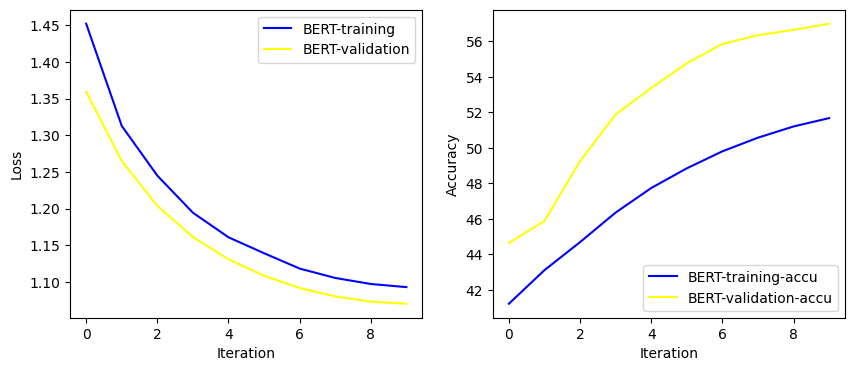

In [35]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

plt.plot(train_loss_his_freeze, label="BERT-training", color="blue")
plt.plot(valid_loss_his_freeze, label="BERT-validation", color="yellow")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_his_freeze, label="BERT-training-accu", color="blue")
plt.plot(valid_acc_his_freeze, label="BERT-validation-accu", color="yellow")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#Fintune Bert
We use the default value of bert_freeze which is to enable the fintune 

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=15)
y_true, y_pred = train(bert_classifier, train_dataloader, val_dataloader, epochs=15, evaluation=True)
y_pred = [t.cpu().numpy() for t in y_pred]
print(classification_report(y_true, y_pred))
print("\n\n")
print(confusion_matrix(y_true, y_pred))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.333936   |     -      |     -     |   17.46  
   1    |   40    |   1.014640   |     -      |     -     |   13.66  
   1    |   60    |   0.934705   |     -      |     -     |   13.67  
   1    |   80    |   0.907420   |     -      |     -     |   13.65  
   1    |   100   |   0.870264   |     -      |     -     |   13.65  
   1    |   120   |   0.822011   |     -      |     -     |   13.66  
   1    |   140   |   0.854207   |     -      |     -     |   13.65  
   1    |   156   |   0.838340   |     -      |     -     |   10.44  
----------------------------------------------------------------------
   1    |    -    |   0.952172   |  0.772737  |   67.41   |  123.35  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elaps

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs= 4)
y_true, y_pred, train_loss_his, train_acc_his, valid_loss_his, valid_acc_his = train(bert_classifier, train_dataloader, val_dataloader, epochs = 4, evaluation=True)
y_pred = [t.cpu().numpy() for t in y_pred]
print(classification_report(y_true, y_pred))
print("\n\n")
print(confusion_matrix(y_true, y_pred))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.337835   |     -      |     -     |   14.39  
   1    |   40    |   1.029079   |     -      |     -     |   13.67  
   1    |   60    |   0.924274   |     -      |     -     |   13.66  
   1    |   80    |   0.915213   |     -      |     -     |   13.66  
   1    |   100   |   0.873163   |     -      |     -     |   13.66  
   1    |   120   |   0.845966   |     -      |     -     |   13.66  
   1    |   140   |   0.839213   |     -      |     -     |   13.66  
   1    |   156   |   0.810095   |     -      |     -     |   10.44  
----------------------------------------------------------------------
Saved model
   1    |    -    |   0.952829   |  0.752957  |   68.85   |  121.29  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val A

In [41]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs= 10)
y_true, y_pred,train_loss_his_10, train_acc_his_10, valid_loss_his_10, valid_acc_his_10 = train(bert_classifier, train_dataloader, val_dataloader, epochs = 10, evaluation=True)
y_pred = [t.cpu().numpy() for t in y_pred]
print(classification_report(y_true, y_pred))
print("\n\n")
print(confusion_matrix(y_true, y_pred))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


OutOfMemoryError: ignored

In [ ]:
print("train_loss_his:",train_loss_his)
print("train_acc_his:",train_acc_his)
print("valid_loss_his:",valid_loss_his)
print("valid_acc_his:",valid_acc_his)

In [ ]:
plt.plot(train_loss_his, label="BERT-training-loss", color="blue", linestyle="dashed")
plt.plot(valid_loss_his, label="BERT-validation-loss", color="blue")
plt.plot(train_acc_his, label="BERT-training-accu", color="blue", linestyle="dashed")
plt.plot(valid_acc_his, label="BERT-validation-accu", color="blue")
plt.xlabel("Iteration")
plt.ylabel("BERT")
plt.legend()

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss_his, label="BERT-training", color="blue", linestyle="dashed")
plt.plot(valid_loss_his, label="BERT-validation", color="blue")
plt.plot(mlp_history.history["loss"], label="MLP-training", color="orange", linestyle="dashed")
plt.plot(mlp_history.history["val_loss"], label="MLP-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(slp_history.history["accuracy"], label="SLP-training", color="blue", linestyle="dashed")
plt.plot(slp_history.history["val_accuracy"], label="SLP-validation", color="blue")
plt.plot(mlp_history.history["accuracy"], label="MLP-training", color="orange", linestyle="dashed")
plt.plot(mlp_history.history["val_accuracy"], label="MLP-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()